In [107]:
# A partir de código de Matheus Klatt:
# https://colab.research.google.com/drive/1ryPL6nAk8OlDw9F5QaYu3GQOqeMEcuZk?usp=sharing#scrollTo=iregsHCQ0hrx

import numpy as np # later try cunumeric as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelos

In [108]:
class modelo():
    def __init__(self, Nx = 300, Nz = 300) -> None:
        self.Nx=Nx#300
        self.Nz=Nz#300
        self.vp=np.zeros((self.Nz, self.Nx))
        self.Na=0
        self.fat = 0
        self.fat_c = np.ones((self.Nz, self.Nx))
    def cria_bordas_cerjan(self,Na = 50,fat=0.0025):
        self.Na = Na
        self.fat = fat

        Nzz = self.Nz + 2*self.Na
        Nxx = self.Nx + 2*self.Na
        ext_vp=np.zeros((Nzz,Nxx))
        ext_vp[Na:-Na,Na:-Na]=self.vp
        for i in range(Na+1):
            ext_vp[i,:]=ext_vp[Na+1,:]
            ext_vp[-i-1,:]=ext_vp[-Na-1,:]
            ext_vp[:,i]=ext_vp[:,Na+1]
            ext_vp[:,-i-1]=ext_vp[:,-Na-1]
        self.vp=ext_vp
        self.Nz=Nzz
        self.Nx=Nxx

#        self.fat_c = [exp(-((self.fat*(Na-i))**2)) for i in range(Na)]
        self.fat_c = np.ones((Nzz,Nxx))
        if Na != 0:
            for i in range(Na):
                self.fat_c[i, :] = np.exp(-((fat * (Na - i)) ** 2))
            for i in range(Nzz - Na, Nzz):
                self.fat_c[i, :] = np.exp(-((fat * (Nzz - Na - i)) ** 2))
            for k in range(Na):
                    self.fat_c[:, k] = np.exp(-((fat * (Na - k)) ** 2)) * self.fat_c[:, Na]
            for k in range(Nxx - Na+1, Nxx):
                    self.fat_c[:, k] = np.exp(-(((fat + 0.5*fat) * (Nxx - Na - k)) ** 2))  * self.fat_c[:, Nxx-Na]
        return self
    def plot(self):
        plt.imshow(self.vp)
    def plot_fator_cerjan(self):
        plt.imshow(self.fat_c)

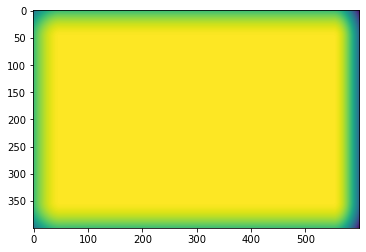

In [109]:
class modelo_paralelas(modelo):
    def __init__(self, Nx = 300, Nz = 300, v = [1500, 3000, 5000]) -> None:
        super().__init__(Nx,Nz)
        self.vp[:int(self.Nz/3),:]=v[0]#1500
        self.vp[int(self.Nz/3):int(2*self.Nz/3),:]=v[1]#3000
        self.vp[int(2*self.Nz/3):,:]=v[2]#5000

modelo_paralelas(500,300).cria_bordas_cerjan().plot_fator_cerjan()

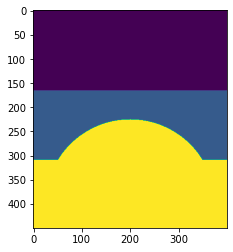

In [110]:
class modelo_circular(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [1500,2500,5000]) -> None:
        super().__init__(Nx,Nz)
        raio = (self.Nz/2)
        raioq = raio**2
        self.vp[:int(self.Nz/3),:]=v[0]
        for k in range(self.Nx):
            cateto_x = abs(k - (self.Nx/2))
            cateto_z = int(np.sqrt(raioq-cateto_x**2)) if cateto_x<raio else 0
            self.vp[int(self.Nz/3):int(self.Nz-cateto_z),k]=v[1]#3000
            self.vp[int(self.Nz-cateto_z):,k]=v[2]#5000

modelo_circular(300,350).cria_bordas_cerjan().plot()

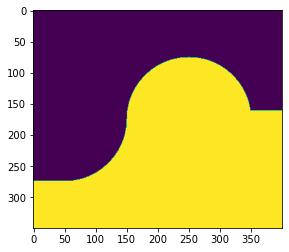

In [111]:
class modelo_dobra(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [2500,3500]) -> None:
        super().__init__(Nx,Nz)
        raio = self.Nx/3
        raioq = raio**2
        centro = self.Nz/2 if self.Nz/2 >= raio+2 else raio+2
        for k in range(self.Nx):
            if k < raio:
                cateto_x = k
                cateto_z = (np.sqrt(raioq-cateto_x**2)) if cateto_x<=raio else 0
                y = centro + cateto_z
                #y = sqrt((raio_dobra ** 2) - ((k+1)**2)) + 150
            else:
                cateto_x = abs(k - (2*self.Nx/3))
                cateto_z = int(np.sqrt(raioq-cateto_x**2)) if cateto_x<raio else 0
                y = centro - cateto_z
                #y = -sqrt((raio ** 2) - (((k+1) - 200) ** 2)) + 150
            self.vp[:int(y),k]=v[0]
            self.vp[int(y):,k]=v[1]
modelo_dobra(300,250).cria_bordas_cerjan().plot()

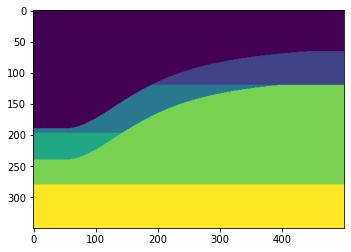

In [112]:
class modelo_reservatorio(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [1500,2000,2500,3000,3500,4000]) -> None:
        super().__init__(Nx,Nz)
        me = 70
        for k in range(self.Nx):
            for i in range(self.Nz):
                y = ((8 * me ** 3) / ((k+1) ** 2 + 4 * me ** 2))

                if i <= y:
                    self.vp[i,k] = v[0]#1500
                elif i < 70:
                    self.vp[i,k] = v[1]#2000
                elif i >= 70 and i < (y + 50) and i < 147:
                    self.vp[i,k] = v[2]#2500
                elif i >= 147 and i < (y + 50):
                    self.vp[i,k] = v[3]#3000
                elif i >= (y + 50) and i < 230:
                    self.vp[i,k] = v[4]#3500
                else:
                    self.vp[i,k] = v[5]#4000

modelo_reservatorio(400,250).cria_bordas_cerjan().plot()

# Fonte

393 5.641895835477563 0.11816359006036772


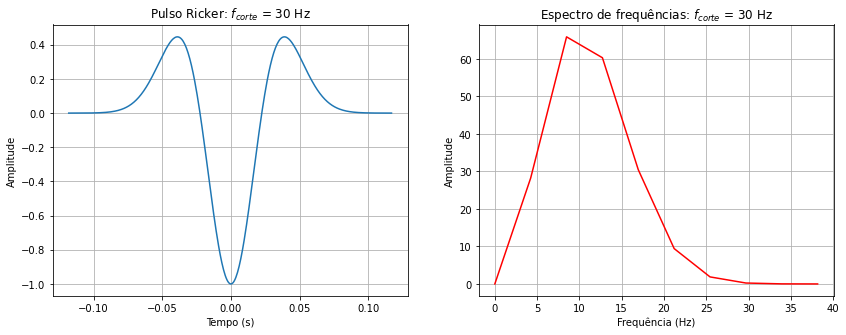

In [116]:
class fonte_sismica():
    def __init__(self,fcorte = 30, dt = 0.0006) -> None:
        self.fcorte = fcorte #30     # frequência de corte (Hz)
        self.dt = dt #0.0006

        self.Nf = int(4 * np.sqrt(np.pi) / (self.fcorte * self.dt)) # Passos de tempo ao longo dos quais a fonte é injetada (tm discretizado)

        self.fonte = np.zeros(self.Nf) # Inicialização do vetor que guarda o as amplitudes do pulso Ricker que é usado como fonte
        self.t = np.zeros(self.Nf) # Inicialização do vetor (td) que guarda os instantes de tempo em segundos nos quais a fonte é aplicada

        self.TF = 2 * np.sqrt(np.pi) / self.fcorte       # Período da função Gaussiana (t0)
        self.fc = self.fcorte / (3. * np.sqrt(np.pi))    # Frequência central

        # Laço que cria o pulso Ricker para cada instante (td) de aplicação da fonte
        for n in range(self.Nf):
            self.t[n] = ((n) * self.dt - self.TF)
            self.fonte[n] = (-np.exp(-np.pi * (np.pi * self.fc * self.t[n]) ** 2) * (1 - 2 * np.pi * (np.pi * self.fc * self.t[n]) * (np.pi * self.fc * self.t[n])))
    
    def plot(self):
        print(self.Nf,self.fc,self.TF)


        fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
        #f_=np.linspace(0,2*self.fcorte,100) # vetor que guarda as frequencias para calculo da transformada da fonte
        #fonte_f = 2*f_**2/(np.pi**2*self.fc**3)*np.exp((-(f_**2)/(np.pi*self.fc**2))) # calculo da transformada de Fourier do pulso Ricker, para as frequencias do vetor 'f_'
        fonte_f = np.abs(np.fft.rfft(self.fonte))
        freq = np.fft.fftfreq(len(self.fonte),self.dt)

        ax0.set_title("Pulso Ricker: " + r'$f_{corte}$' + " = {} Hz".format(self.fcorte))
        #ax0.plot(self.t+self.TF, self.fonte) # Plot do pulso Ricker a partir do tempo 0.0s até tm
        ax0.plot(self.t,self.fonte) # Plot do pulso Ricker a partir do tempo 0.0s até tm
        ax0.set_xlabel("Tempo (s)")
        ax0.set_ylabel("Amplitude")
        ax1.set_title("Espectro de frequências: " + r'$f_{corte}$' + " = {} Hz".format(self.fcorte)) 
        ax1.plot(freq[:10],fonte_f[:10],c="red") # Plot do espectro de frequencias do pulso Ricker para as frequencias contidas no vetor 'f_'
        ax1.set_xlabel("Frequência (Hz)")
        ax1.set_ylabel("Amplitude")
        ax0.grid()
        ax1.grid()

fonte_sismica().plot()       

# Malha

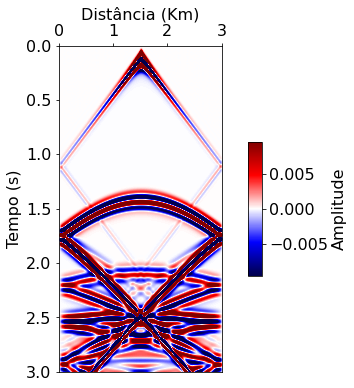

In [ ]:
class malha():
    def __init__(self, modelo, fonte) -> None:
        self.mod = modelo
        self.fnt = fonte

        self.h = 10
        self.C = np.zeros((self.mod.Nz, self.mod.Nx))                # Matriz para simplificação da equação da onda discretizada
        self.A = np.zeros((self.mod.Nz, self.mod.Nx))                # Matriz para simplificação da equação de bordas não reflexivas

        for i in range(self.mod.Nz):
            for k in range(self.mod.Nx):
                self.A[i, k] = self.mod.vp[i, k] * (self.fnt.dt/self.h)
                self.C[i, k] = - (self.A[i, k] ** 2) / 12
        
        self.rec_shotz = 5 # profundidade, em pontos da malha, dos receptores (horizontalmente os receptores estão em todos os pontos nessa profundidade [rec_shotz,:])
        self.init_shot_z = 5 # posição vertical, em pontos da malha, da fonte sísmica
        self.init_shot_x = 150 # posição horizontal, em pontos da malha, da fonte sísmica
        self.ntotal = 5000 # duração total, em passos de tempo, da simulação da propagação da onda sísmica

        self.P1 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo passado
        self.P2 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo presente
        self.P3 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo futuro
        self.sis = np.zeros((self.ntotal, self.mod.Nx))          # Matriz do sismograma

    def modelagem(self):
        for n in range(self.ntotal):
            # Termo fonte
            if n < self.fnt.Nf:
                v = self.A[self.init_shot_z, self.init_shot_x]
                self.P2[self.init_shot_z, self.init_shot_x] = self.P2[self.init_shot_z, self.init_shot_x] + (self.fnt.fonte[n] * v*v)         

            # Cálculo do Campo no interior do modelo 4E2T
            self.P3[2:-2, 2:-2] = \
                self.C[2:-2,2:-2] * ( \
                    self.P2[2:-2, 4:] + self.P2[2:-2, :-4] + self.P2[4:, 2:-2] + self.P2[:-4, 2:-2] \
                    - 16 * (self.P2[2:-2, 3:-1] + self.P2[2:-2, 1:-3] + self.P2[3:-1, 2:-2] + self.P2[1:-3, 2:-2]) \
                    + 60 * (self.P2[2:-2, 2:-2]) \
                ) + 2 * (self.P2[2:-2, 2:-2]) - self.P1[2:-2, 2:-2]
            # Atualização do campo de onda
            self.P1 = self.P2
            self.P2 = self.P3
            self.P3 = self.P3.copy()
            
            # Registro no sismograma de eventos detectados na posição dos receptores no passo de tempo atual
            for k in range (self.mod.Nx):
                self.sis[n, k] = self.P3[self.rec_shotz,k]
            
            # Impressão do andamento da modelagem a cada 1000 passos de tempo
            #if n % 1000 == 0:
            #    print(n)
        return self

    def plot(self):
        sis_homogeneo=0

        ## Eixos em dimensões reais
        scaleX = 1.0 / 1000
        scaleZ = 1

        Xmin = (0 * self.h) * scaleX
        Xmax = (self.mod.Nx * self.h) * scaleX
        Zmin = (0 * self.fnt.dt) * scaleZ
        Zmax = (self.ntotal * self.fnt.dt) * scaleZ


        ## Eixo horizontal no topo da figura
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['xtick.labelbottom'] = False
        plt.rcParams['xtick.top'] = True
        plt.rcParams['xtick.labeltop'] = True

        plt.rc('xtick', labelsize=16)   
        plt.rc('ytick', labelsize=16)
        plt.rcParams.update({'font.size':16})

        max_sis = np.max(np.abs(self.sis))
        
        ## Formatação do plot
        fig, ax = plt.subplots(figsize=(6,6))
        ax.xaxis.set_label_position('top')
        if (type(sis_homogeneo)==type(self.sis)):
            im = ax.imshow(np.add(self.sis,-sis_homogeneo), cmap='seismic', vmin=-max_sis*50**(-1), vmax=max_sis*50**(-1), extent=[Xmin,Xmax,Zmax,Zmin], interpolation='bicubic', aspect=2) 
        else:
            im = ax.imshow(self.sis, cmap='seismic', vmin=-max_sis*50**(-1), vmax=max_sis*50**(-1), extent=[Xmin,Xmax,Zmax,Zmin], interpolation='bicubic', aspect=2)
        cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.08, label='Amplitude', aspect=10)
        plt.xlabel('Distância (Km)', fontsize=16)
        plt.ylabel('Tempo (s)', fontsize=16)
        plt.show()

malha(modelo_paralelas(),fonte_sismica()).modelagem().plot()